# Project 1: Image Classification

## Task 0: Getting Started

Read the getting started guide titled **"Python for Deep Learning"** and get familiar with Python and PyTorch. Read the provided code below and get familiar with the commands and their parameters to understand what the code is trying to do. We recommend to spend a fair amount of time to understand all the different parts of the code. This understanding will be important for this and future projects.

The goal of this project is to implement the *“Hello World!”* program of deep learning: designing and training a network that performs image classification. The dataset we will be using is CIFAR10 which is a large set of images that are classified into 10 classes (airplane, bird, cat, etc.).

## Task 1:  Data Loading (10 points)
Complete the **DataLoader** below which we will use to load images of the cifar10 dataset provided by torchvision. Your task is to normalize it by shifting and scaling it by a factor of 0.5. For the training set, introduce random transformations (e.g. flips) for data augmentation.

In [0]:
from __future__ import print_function, division

import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image
import matplotlib.pyplot as plt
plt.ion()   # interactive mode


# Data augmentation and normalization for training
# Just normalization for testing
data_transforms = {
    'train': transforms.Compose([
    # TODO Task 1:  Training transofrmations
        transforms.RandomCrop(32, padding=2),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

    ]),
    'test': transforms.Compose([
    # TODO Task 1:  Test transofrmations
                
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        
    ])
}

# Load CIFAR10
image_datasets = {x: torchvision.datasets.CIFAR10(root='./data', train=(x=='train'), download=True, transform=data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=(x=='train'), num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# Move to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

0it [00:00, ?it/s]

 99%|█████████▉| 168927232/170498071 [00:11<00:00, 16777270.12it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Visualize a few images

Let’s visualize a few training images so as to understand the data augmentations. The results should look like:

<img src="https://i.imgur.com/Sa6l1go.png" width="400" align="left">

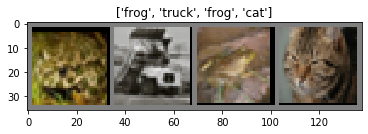

In [0]:
# TODO Task 1:  Run this cell and try to understand the output of each step

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Task 2: Basic Networks (20 points)
1. Create a Fully connected Network (FcNet) as follows in the Jupyter Notebook:
```
FcNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)
```
Train the FcNet for **3** epoches and record the training time and accuracy in your final report.

2. Create a Convolutional Network (ConvNet) as follows in the Jupyter Notebook:
```
ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
```
Train the ConvNet for **3** epoches and record the training time and accuracy in your final report. 

*Use the default SGD optimizer ( lr=0.001, momentum=0.9) for training.

### Model training code (do not modify except for plotting the loss curve)

In [0]:
def train_model(model, criterion, optimizer, num_epochs=25, save_path='saved_weight.pth'):
    since = time.time()
    loss_curve = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train': model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            loss_curve.append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    plt.plot(range(len(loss_curve)), loss_curve)
    torch.save(model.state_dict(), save_path)
    return model

### 1) FC Network

In [0]:
# 1) Define a Fully Connected Neural Network
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        # TODO Task 2:  Define the layers
        self.fc1 = nn.Linear(3072, 1024, bias=True)
        self.fc2 = nn.Linear(1024,400, bias=True)
        self.fc3 = nn.Linear(400, 80, bias=True)
        self.fc4 = nn.Linear(80, 10, bias=True)

    def forward(self, x):
        # TODO Task 2:  Define the forward pass
        x = x.view(-1, 3072)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

model_ft = FcNet()
model_ft = model_ft.to(device)
print(model_ft)
optimizer = torch.optim.SGD(model_ft.parameters() ,  lr=0.001, momentum=0.9 )
#train_model(model_ft, nn.CrossEntropyLoss() , optimizer, num_epochs=3, save_path='saved_weight.pth')

FcNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=80, bias=True)
  (fc4): Linear(in_features=80, out_features=10, bias=True)
)


### 2) CNN

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 0/2
----------
train Loss: 1.7521 Acc: 0.3548
Epoch 1/2
----------
train Loss: 1.3858 Acc: 0.5021
Epoch 2/2
----------
train Loss: 1.2549 Acc: 0.5540

Training complete in 2m 24s


ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

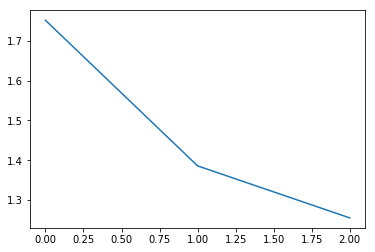

In [0]:
# 2) Define a Convolutional Neural Network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
        self.pool1  = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
        self.pool2  = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        self.fc1 = nn.Linear(400, 120, bias=True)
        self.fc2 = nn.Linear(120,84, bias=True)
        self.fc3 = nn.Linear(84, 10, bias=True)
    def forward(self, x):
        # TODO Task 2:  Define the forward pass
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x) 
        return x

model_ft = ConvNet()
model_ft = model_ft.to(device)
print(model_ft)
optimizer = torch.optim.SGD(model_ft.parameters() ,  lr=0.001, momentum=0.9 )
train_model(model_ft, nn.CrossEntropyLoss() , optimizer, num_epochs=3, save_path='saved_weight.pth')

## Task 3: Design Your Network I (20 points)
Define your own Convolutional Network (MyNet) starting from the configuration in Task 2.2. Add following modifications and train the Network for **25** epoches. Keep the best settings for each step (for each step, record the training accuracy of the last epoch and test accuracy in your report):

1. Increase the number of layers: Modify the number of convolutional layers in the network.
2. Increase the number of filters: Modify the number of filters in each convolutional layer of the network. 
3. Modify the filter sizes in each convolutional layer. Experiment with different filter sizes (3x3, 5x5 and 7x7).

## Task 4: Design Your Network II (20 points)
Keeping the best settings of Task 3, use **Dropout** in fully connected layers and Batch Normalization (choose a suitable batch size) in convolutional layers. Record the training accuracy of the last epoch and test accuracy in your report.

### Design Your Network

In [0]:
# Define a Convolutional Neural Network
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # TODO Task 3 & 4: Design Your Network I & II 
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        self.bn2 = nn.BatchNorm2d(32)

        self.pool1  = nn.MaxPool2d(kernel_size=2, stride=1, padding=0,  ceil_mode=False)

          
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
        self.bn4 = nn.BatchNorm2d(64)

        self.pool2  = nn.MaxPool2d(kernel_size=2, stride=1, padding=0, ceil_mode=False)

          
        self.conv5 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        self.bn5 = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        self.bn6 = nn.BatchNorm2d(64)

        self.pool3  = nn.MaxPool2d(kernel_size=2, stride=1, padding=0, ceil_mode=False)

        self.fc1 = nn.Linear(3136, 1024, bias=True)
        self.fc2 = nn.Linear(1024,256, bias=True)
        self.fc3 = nn.Linear(256, 10, bias=True)
        
        self.dropout = nn.Dropout(0.2)
        
        self.featuremap1 = 0
        self.featuremap2 = 0

    def forward(self, x):
        # TODO Task 3 & 4: Design Your Network I & II
        
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)        
        self.featuremap1 = x

        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool1(x)
      
      
      
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        
        self.featuremap2 = x

        
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x) 
        return x



In [0]:
model_ft = MyNet()
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# TODO Task 5: Optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

Epoch 0/24
----------
train Loss: 1.6767 Acc: 0.3927
Epoch 1/24
----------
train Loss: 1.2957 Acc: 0.5435
Epoch 2/24
----------
train Loss: 1.1253 Acc: 0.6057
Epoch 3/24
----------
train Loss: 1.0281 Acc: 0.6404
Epoch 4/24
----------
train Loss: 0.9501 Acc: 0.6689
Epoch 5/24
----------
train Loss: 0.9020 Acc: 0.6877
Epoch 6/24
----------
train Loss: 0.8551 Acc: 0.7038
Epoch 7/24
----------
train Loss: 0.8168 Acc: 0.7178
Epoch 8/24
----------
train Loss: 0.7796 Acc: 0.7292
Epoch 9/24
----------
train Loss: 0.7554 Acc: 0.7401
Epoch 10/24
----------
train Loss: 0.7294 Acc: 0.7485
Epoch 11/24
----------
train Loss: 0.7099 Acc: 0.7554
Epoch 12/24
----------
train Loss: 0.6885 Acc: 0.7653
Epoch 13/24
----------
train Loss: 0.6663 Acc: 0.7715
Epoch 14/24
----------
train Loss: 0.6516 Acc: 0.7753
Epoch 15/24
----------
train Loss: 0.6369 Acc: 0.7830
Epoch 16/24
----------
train Loss: 0.6198 Acc: 0.7881
Epoch 17/24
----------
train Loss: 0.6079 Acc: 0.7924
Epoch 18/24
----------
train Loss: 0.5

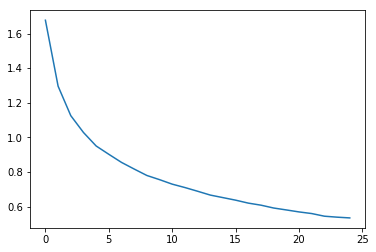

In [0]:
## Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=25)

## Task 5: The Optimizer (20 points)
Keeping the best settings of Task 4, use 3 different optimizers (SGD, ADAM and RMSProp) with 3 different learning rates (0.001, 0.01, 0.1) . Plot the loss curves (Training loss vs Training step) for each case.

Epoch 0/9
----------
train Loss: 1.8332 Acc: 0.3216
Epoch 1/9
----------
train Loss: 1.4624 Acc: 0.4767
Epoch 2/9
----------
train Loss: 1.2918 Acc: 0.5416
Epoch 3/9
----------
train Loss: 1.1793 Acc: 0.5866
Epoch 4/9
----------
train Loss: 1.1025 Acc: 0.6113
Epoch 5/9
----------
train Loss: 1.0337 Acc: 0.6360
Epoch 6/9
----------
train Loss: 0.9847 Acc: 0.6540
Epoch 7/9
----------
train Loss: 0.9386 Acc: 0.6726
Epoch 8/9
----------
train Loss: 0.9026 Acc: 0.6847
Epoch 9/9
----------
train Loss: 0.8696 Acc: 0.6975

Training complete in 21m 17s
Epoch 0/9
----------
train Loss: 1.6534 Acc: 0.3990
Epoch 1/9
----------
train Loss: 1.2913 Acc: 0.5458
Epoch 2/9
----------
train Loss: 1.1223 Acc: 0.6039
Epoch 3/9
----------
train Loss: 1.0210 Acc: 0.6435
Epoch 4/9
----------
train Loss: 0.9548 Acc: 0.6680
Epoch 5/9
----------
train Loss: 0.8939 Acc: 0.6882
Epoch 6/9
----------
train Loss: 0.8538 Acc: 0.7038
Epoch 7/9
----------
train Loss: 0.8203 Acc: 0.7149
Epoch 8/9
----------
train Loss: 0

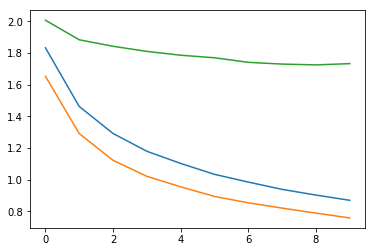

In [0]:
for lr in [0.001, 0.01, 0.1]:
  model_ft = MyNet()
  model_ft = model_ft.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr)
  train_model(model_ft, criterion, optimizer_ft, num_epochs=10)
  
  

  
    

Epoch 0/9
----------
train Loss: 1.8511 Acc: 0.3121
Epoch 1/9
----------
train Loss: 1.5555 Acc: 0.4398
Epoch 2/9
----------
train Loss: 1.4275 Acc: 0.4929
Epoch 3/9
----------
train Loss: 1.3350 Acc: 0.5274
Epoch 4/9
----------
train Loss: 1.2784 Acc: 0.5511
Epoch 5/9
----------
train Loss: 1.2258 Acc: 0.5720
Epoch 6/9
----------
train Loss: 1.1953 Acc: 0.5824
Epoch 7/9
----------
train Loss: 1.1639 Acc: 0.5963
Epoch 8/9
----------
train Loss: 1.1332 Acc: 0.6070
Epoch 9/9
----------
train Loss: 1.1165 Acc: 0.6138

Training complete in 18m 43s
Epoch 0/9
----------
train Loss: 2.2323 Acc: 0.1550
Epoch 1/9
----------
train Loss: 2.1846 Acc: 0.1676
Epoch 2/9
----------
train Loss: 2.1848 Acc: 0.1672
Epoch 3/9
----------
train Loss: 2.1714 Acc: 0.1674
Epoch 4/9
----------
train Loss: 2.1562 Acc: 0.1706
Epoch 5/9
----------
train Loss: 2.1453 Acc: 0.1684
Epoch 6/9
----------
train Loss: 2.1411 Acc: 0.1686
Epoch 7/9
----------
train Loss: 2.1357 Acc: 0.1700
Epoch 8/9
----------
train Loss: 2

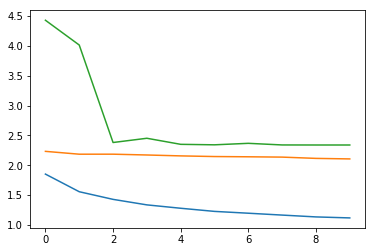

In [0]:
for lr in [0.001, 0.01, 0.1]:
  model_ft = MyNet()
  model_ft = model_ft.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer_ft = optim.Adam(model_ft.parameters(), lr=lr)
  train_model(model_ft, criterion, optimizer_ft, num_epochs=10)
  



In [0]:
for lr in [0.001, 0.01, 0.1]:
  model_ft = MyNet()
  model_ft = model_ft.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=lr)
  train_model(model_ft, criterion, optimizer_ft, num_epochs=10)
  

### Testing the Accuracy

In [0]:
def test_model(model, load_path='saved_weight.pth'):    
    # load the model weights
    model.load_state_dict(torch.load(load_path))
    
    since = time.time()

    for phase in ['test']:
        if phase == 'test':
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

            # statistics
            running_corrects += torch.sum(preds == labels.data)
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Acc: {:.4f}'.format(phase, epoch_acc))

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return 

In [0]:
test_model(model_ft)
print(model_ft)


test Acc: 0.8269
Testing complete in 0m 11s
MyNet(
  (conv1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 64, ke

### Display model predictions

In [0]:
## Display model predictions
## Generic function to display predictions for a few images

def display_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

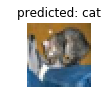

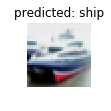

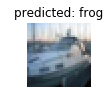

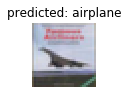

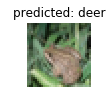

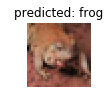

In [0]:
display_predictions(model_ft)

## Task 6: Visualization (10 points)
Visualize feature maps of the first and the last convolutional layer of your final network using **cifar_example.jpg** as input image. Show the visualization in the report.

#### First layer activations
<img src="https://i.imgur.com/kGB9AuP.png" width="400" align="left">

#### Last layer activations

<img src="https://i.imgur.com/qelH05X.png" width="400" align="left">

## Save the Feature Maps

In [0]:
# TODO Task 6: Visualization

In [0]:
def transfer_single_img_to_tensor(img_path):
    im = Image.open(img_path)
    img = np.asarray(im)/255
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    inp = (img - mean) / std
    inp = np.asarray(inp, dtype=np.float32)
    inp = inp.transpose((2, 0, 1))
    inp = np.expand_dims(inp, axis=0)
    inp = torch.from_numpy(inp, )
    inputs = inp.to(device)
    return inputs

In [0]:
from google.colab import files
uploaded = files.upload()


inputs = transfer_single_img_to_tensor('cifar_example.jpg')
model_ft.eval()
with torch.no_grad():
    model_ft(inputs)

Saving cifar_example.jpg to cifar_example (1).jpg


In [0]:
# Model_ft.featuremap1 and model_ft.featuremap2 should be the first and the last feature maps.
# Add model_ft.featuremap1 and model_ft.featuremap2 at suitable places in your network

feature_ouput1 = model_ft.featuremap1.transpose(1,0).cpu()
feature_ouput2 = model_ft.featuremap2.transpose(1,0).cpu()

In [0]:
def feature_imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

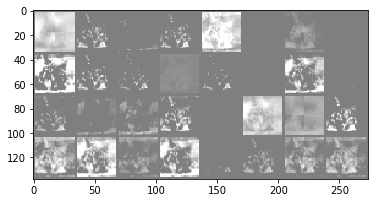

In [0]:
out = torchvision.utils.make_grid(feature_ouput1)
feature_imshow(out)

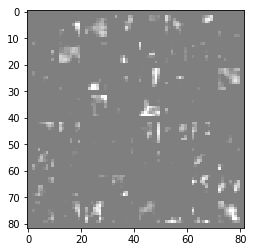

In [0]:
out = torchvision.utils.make_grid(feature_ouput2)
feature_imshow(out)